In [1]:
from datetime import date
import gdal
import time
import requests
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
import os, shutil
from glob import glob
%matplotlib inline  
from shapely.geometry import Polygon
import json



In [2]:
west=gpd.read_file('../shp/Turkey_border.shp')

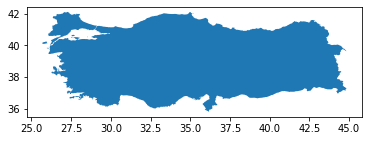

In [5]:
west.plot()

In [35]:
#data from http://geojson.io 
data={
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              38.54827880859375,
              36.90378362619561
            ],
            [
              40.0067138671875,
              36.90378362619561
            ],
            [
              40.0067138671875,
              37.89219554724437
            ],
            [
              38.54827880859375,
              37.89219554724437
            ],
            [
              38.54827880859375,
              36.90378362619561
            ]
          ]
        ]
      }
    }
  ]
}

In [36]:
datajson=json.dumps(data)

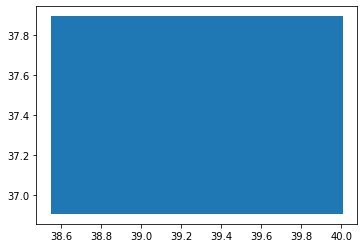

In [37]:
west=gpd.read_file(datajson)
west.plot()

In [38]:
west.crs

{'init': 'epsg:4326'}

In [39]:
wrs = gpd.GeoDataFrame.from_file("../shp/WRS2_descending.shp")

In [40]:
len(wrs)

28892

In [41]:
#intersect target area with landsat path-row 
wrs_intersection = wrs[wrs.intersects(west.geometry[0])]

In [42]:
wrs_intersection

,AREA,PERIMETER,PR_,PR_ID,RINGS_OK,RINGS_NOK,PATH,ROW,MODE,SEQUENCE,WRSPR,PR,ACQDayL7,ACQDayL8,geometry
3133,3.22740,7.29533,2762.0,2762.0,1,0,173,34,D,4746,173034,173034,2,10,"POLYGON ((39.36965344531275 36.66675883503565,..."
19377,3.22725,7.29513,2762.0,2762.0,1,0,172,34,D,37234,172034,172034,11,3,"POLYGON ((40.91465316013049 36.66675792197824,..."
19378,3.16913,7.21705,2763.0,2763.0,1,0,172,35,D,37235,172035,172035,11,3,"POLYGON ((38.46678991078875 35.48569432422082,..."


In [43]:
len(wrs_intersection)

3

In [44]:
paths, rows = wrs_intersection['PATH'].values, wrs_intersection['ROW'].values

In [45]:
paths, rows

(array([173, 172, 172]), array([34, 34, 35]))

In [46]:
paths_rows=[]
for i in range(len(paths)):
    intersectimage=[paths[i],rows[i]]
    paths_rows.append(intersectimage)

In [47]:
# Get the center of the map
xy = np.asarray(west.centroid[0].xy).squeeze()
center = list(xy[::-1])
zoom = 8
# Create the most basic OSM folium map
m = folium.Map(location=center, zoom_start=zoom)
# Add the bounds GeoDataFrame in red
m.add_child(folium.GeoJson(west.__geo_interface__, name='Area of Study', 
                           style_function=lambda x: {'color': 'red', 'alpha': 0}))
m

In [48]:
# Iterate through each Polygon of paths and rows intersecting the area
for i, row in wrs_intersection.iterrows():

    # Create a string for the name containing the path and row of this Polygon
    name = 'path: %03d, row: %03d' % (row.PATH, row.ROW)
    # Create the folium geometry of this Polygon 
    g = folium.GeoJson(row.geometry.__geo_interface__, name=name)
    # Add a folium Popup object with the name string
    g.add_child(folium.Popup(name))
    # Add the object to the map
    g.add_to(m)

    

In [49]:
folium.LayerControl().add_to(m)
m

In [50]:
s3_scenes = pd.read_csv('http://landsat-pds.s3.amazonaws.com/c1/L8/scene_list.gz', compression='gzip')

In [51]:
s3_scenes.head()


,productId,entityId,acquisitionDate,cloudCover,processingLevel,path,row,min_lat,min_lon,max_lat,max_lon,download_url
0,LC08_L1TP_149039_20170411_20170415_01_T1,LC81490392017101LGN00,2017-04-11 05:36:29.349932,0.00,L1TP,149,39,29.22165,72.41205,31.34742,74.84666,https://s3-us-west-2.amazonaws.com/landsat-pds...
1,LC08_L1TP_012001_20170411_20170415_01_T1,LC80120012017101LGN00,2017-04-11 15:14:40.001201,0.15,L1TP,12,1,79.51504,-22.06995,81.90314,-7.44339,https://s3-us-west-2.amazonaws.com/landsat-pds...
2,LC08_L1TP_012002_20170411_20170415_01_T1,LC80120022017101LGN00,2017-04-11 15:15:03.871058,0.38,L1TP,12,2,78.74882,-29.24387,81.14549,-15.04330,https://s3-us-west-2.amazonaws.com/landsat-pds...
3,LC08_L1TP_012010_20170411_20170415_01_T1,LC80120102017101LGN00,2017-04-11 15:18:14.918879,0.02,L1TP,12,10,69.67856,-56.04655,72.02949,-48.71678,https://s3-us-west-2.amazonaws.com/landsat-pds...
4,LC08_L1TP_012011_20170411_20170415_01_T1,LC80120112017101LGN00,2017-04-11 15:18:38.780265,10.65,L1TP,12,11,68.38187,-57.33186,70.76840,-51.13822,https://s3-us-west-2.amazonaws.com/landsat-pds...


In [52]:
min_date='2018-07-01'
max_date='2018-07-30'

In [53]:
# Empty list to add the images
bulk_list = []

# Iterate through paths and rows
for path, row in zip(paths, rows):

    print('Path:',path, 'Row:', row)

    # Filter the Landsat Amazon S3 table for images matching path, row, cloudcover and processing state.
    scenes = s3_scenes[(s3_scenes.path == path) & (s3_scenes.row == row) &
                       ((s3_scenes['acquisitionDate']>=min_date )&(s3_scenes['acquisitionDate']<=max_date ))&
                       (s3_scenes.cloudCover <= 80) & 
                       (~s3_scenes.productId.str.contains('_T2')) &
                       (~s3_scenes.productId.str.contains('_RT'))]
    print(' Found {} images\n'.format(len(scenes)))

    # If any scenes exists, select the one that have the minimum cloudCover.
    if len(scenes):
        scene = scenes.sort_values('cloudCover').iloc[0]

    # Add the selected scene to the bulk download list.
    bulk_list.append(scene)


Path: 173 Row: 34
 Found 2 images

Path: 172 Row: 34
 Found 2 images

Path: 172 Row: 35
 Found 3 images



In [56]:
bulk_list

[productId                   LC08_L1TP_173034_20180711_20180717_01_T1
 entityId                                       LC81730342018192LGN00
 acquisitionDate                           2018-07-11 08:02:28.153957
 cloudCover                                                         0
 processingLevel                                                 L1TP
 path                                                             173
 row                                                               34
 min_lat                                                      36.3942
 min_lon                                                      37.2598
 max_lat                                                      38.5214
 max_lon                                                      39.8978
 download_url       https://s3-us-west-2.amazonaws.com/landsat-pds...
 Name: 584327, dtype: object,
 productId                   LC08_L1TP_172034_20180704_20180717_01_T1
 entityId                                       LC8172034201

In [57]:
bulk_list_new=[]
for index,i in enumerate(bulk_list,0):
    if i.productId!=bulk_list[index-1].productId:
        bulk_list_new.append(i)
    elif len(bulk_list)==1:
        bulk_list_new.append(i)
        
len(bulk_list_new)

3

In [58]:
bulk_frame_result = pd.concat(bulk_list_new, 1).T


In [59]:
bulk_frame_result.sort_values('cloudCover',ascending=True)

,productId,entityId,acquisitionDate,cloudCover,processingLevel,path,row,min_lat,min_lon,max_lat,max_lon,download_url
584327,LC08_L1TP_173034_20180711_20180717_01_T1,LC81730342018192LGN00,2018-07-11 08:02:28.153957,0,L1TP,173,34,36.3942,37.2598,38.5214,39.8978,https://s3-us-west-2.amazonaws.com/landsat-pds...
573660,LC08_L1TP_172034_20180704_20180717_01_T1,LC81720342018185LGN00,2018-07-04 07:56:13.941546,0,L1TP,172,34,36.3982,38.8394,38.5288,41.4063,https://s3-us-west-2.amazonaws.com/landsat-pds...
583578,LC08_L1TP_172035_20180704_20180717_01_T1,LC81720352018185LGN00,2018-07-04 07:56:37.828349,0,L1TP,172,35,34.9701,38.434,37.0945,40.9695,https://s3-us-west-2.amazonaws.com/landsat-pds...


## Delete image from bulk_frame_result according to path-row information
bulk_frame.loc[(bulk_frame['path']==172) & (bulk_frame['row']==35)]

bulk_frame=bulk_frame.drop(productId)

bulk_frame

In [60]:
zoom = 6
# Create the new map from selected images
n = folium.Map(location=center, zoom_start=zoom)

In [61]:
# Iterate through each Polygon of paths and rows intersecting the area
for i, row in bulk_frame_result.iterrows():
    #image=bulk_frame_result.loc[i]    
    lat_point_list = [row.max_lat, row.max_lat, row.min_lat,row.min_lat] 
    lon_point_list = [row.min_lon, row.max_lon, row.max_lon,row.min_lon]
    polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
    crs = {'init': 'epsg:4326'}
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])    
    # Create a string for the name containing the path and row of this Polygon
    name = 'path: %03d, row: %03d' % (row.path, row.row)
    # Create the folium geometry of this Polygon 
    g = folium.GeoJson(polygon.__geo_interface__, name=name)
    # Add a folium Popup object with the name string
    g.add_child(folium.Popup(name))
    # Add the object to the map
    g.add_to(n)
    

In [62]:
folium.LayerControl().add_to(n)
n.save('results.html')
n

In [63]:
def ImageDownload(bandlist,bulk_frame,download_path='./'):
    start_time = time.time()
    for i,row in bulk_frame.iterrows():
                
        for band in bandlist:                                                                  
            response = requests.get(row.download_url)
            if response.status_code == 200:
                if os.path.exists(download_path+row.productId)==False:
                    os.makedirs(download_path+row.productId)
                    
                
                image_dir=download_path+row.productId+'/'
                print(image_dir)
                url = row.download_url[:-10]
                image = row.productId+'_B{}.TIF'.format(band)
                image_path=image_dir+image
                response = requests.get(url+image, stream=True)
                #translate_path=image_dir+'4326/'+image
                #print(translate_path)
                
                with open(os.path.join(image_path), 'wb') as output:
                    shutil.copyfileobj(response.raw, output)
                    #gdal.Warp(translate_path ,image_path, format = 'GTiff', dstSRS = 'EPSG:4326',srcNodata = 0,dstNodata=0)
                
                
                del response
                
        metadata=row.productId+'_MTL.json'
        response_MTL = requests.get(url+metadata, stream=True)
    
        with open(os.path.join(image_dir+metadata), 'wb') as output:
            shutil.copyfileobj(response_MTL.raw, output)
        del response_MTL
        print(image_dir+metadata)
        quality_ass=row.productId+'_BQA.TIF'
        response_QA = requests.get(url+quality_ass, stream=True)
        
        with open(os.path.join(image_dir+quality_ass), 'wb') as output:
            shutil.copyfileobj(response_QA.raw, output)
        print(image_dir+quality_ass)
    print("--- %s seconds ---" % (time.time() - start_time))

In [64]:
download_path='../mardin/'
if not os.path.isdir(download_path):
    os.mkdir(download_path)

In [65]:
#https://www.usgs.gov/faqs/what-are-best-landsat-spectral-bands-use-my-research?qt-news_science_products=0#qt-news_science_products
landsat_bands={'coastal aerosol':1,'blue':2,'green':3,'red':4,'Near Infrared (NIR)':5,
              'Short-wave Infrared(SWIR)1':6,'Short-wave Infrared(SWIR)2':7,'Panchromatic':8,
              'Cirrus':9,'TIRS1':10,'TIRS2':11}

In [66]:
#bands=[2,3,4,5,6,7,8,9,10]
bands=[2,3,4,5]

In [67]:
ImageDownload(bands,bulk_frame_result,download_path)

../mardin/LC08_L1TP_173034_20180711_20180717_01_T1/
../mardin/LC08_L1TP_173034_20180711_20180717_01_T1/
../mardin/LC08_L1TP_173034_20180711_20180717_01_T1/
../mardin/LC08_L1TP_173034_20180711_20180717_01_T1/
../mardin/LC08_L1TP_173034_20180711_20180717_01_T1/LC08_L1TP_173034_20180711_20180717_01_T1_MTL.json
../mardin/LC08_L1TP_173034_20180711_20180717_01_T1/LC08_L1TP_173034_20180711_20180717_01_T1_BQA.TIF
../mardin/LC08_L1TP_172034_20180704_20180717_01_T1/
../mardin/LC08_L1TP_172034_20180704_20180717_01_T1/
../mardin/LC08_L1TP_172034_20180704_20180717_01_T1/
../mardin/LC08_L1TP_172034_20180704_20180717_01_T1/
../mardin/LC08_L1TP_172034_20180704_20180717_01_T1/LC08_L1TP_172034_20180704_20180717_01_T1_MTL.json
../mardin/LC08_L1TP_172034_20180704_20180717_01_T1/LC08_L1TP_172034_20180704_20180717_01_T1_BQA.TIF
../mardin/LC08_L1TP_172035_20180704_20180717_01_T1/
../mardin/LC08_L1TP_172035_20180704_20180717_01_T1/
../mardin/LC08_L1TP_172035_20180704_20180717_01_T1/
../mardin/LC08_L1TP_172035